# VAR Model

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
with open('../sql-scripts/var.txt', 'r') as sql_file:
  sql_script = sql_file.read()

conn = sqlite3.connect('orlando.db')
var_df = pd.read_sql_query(sql_script, conn)
conn.close()

## Fit the model

In [3]:
# Container to store VAR results for each neighborhood
grouped_results = {}

# Group the data by neighborhood
for neighborhood, group_df in var_df.groupby("neighborhood"):
  # Drop the 'neighborhood', 'distance', and 'duration' columns as they're not used in the VAR model
  group_df = group_df.drop(columns=["neighborhood", "distance", "duration"])
  
  # Ensure the data is sorted by index (if applicable)
  group_df = group_df.sort_index()
  
  # Apply second differencing
  group_df = group_df.diff().diff().dropna()

  # Check if enough data points are available after differencing
  if len(group_df) <= 1:  # At least 2 data points needed for lag 1
    print(f"Skipping {neighborhood} due to insufficient data after differencing.")
    continue
  
  # Fit the VAR model, automatically determining the maximum lag
  model = VAR(group_df)
  
  # Try fitting with a different method to handle potential singularity
      # Using 'aic' to select the lag order that minimizes the AIC
  results = model.fit() 
  
  # Store the results
  grouped_results[neighborhood] = results

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index

Skipping Beltway Commerce Center due to insufficient data after differencing.
Skipping City of Orlando/GOAA due to insufficient data after differencing.
Skipping Colonial Town Center due to insufficient data after differencing.
Skipping Countryside due to insufficient data after differencing.
Skipping Lake Davis/Greenwood due to insufficient data after differencing.
Skipping Lake Dot due to insufficient data after differencing.
Skipping Lake Fairview due to insufficient data after differencing.
Skipping Lake Fredrica due to insufficient data after differencing.
Skipping Lake Holden due to insufficient data after differencing.
Skipping New Malibu due to insufficient data after differencing.
Skipping Pershing due to insufficient data after differencing.
Skipping South Division due to insufficient data after differencing.
Skipping Vista Park due to insufficient data after differencing.


c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index

## Forecast model

In [4]:
forecast_results = {}

for neighborhood, results in grouped_results.items():
  # Generate forecasts for the next 8 periods (years)
  forecast_steps = 8
  forecast = results.forecast(results.endog[-results.k_ar:], steps=forecast_steps)

  # Create a DataFrame to display the forecast results
  forecast_df = pd.DataFrame(forecast, columns=results.names, index=range(2022, 2022 + forecast_steps))
  forecast_results[neighborhood] = forecast_df

# Create a DataFrame to store the forecasted Zillow values for each neighborhood
forecast_horizon_df = pd.DataFrame()

# Loop through each neighborhood in forecast_horizon_df
for neighborhood, forecast_df in forecast_results.items():
  # Retrieve the last two actual home prices from var_df for the current neighborhood
  neighborhood_data = var_df[var_df["neighborhood"] == neighborhood].sort_values("year")
  hp_2020 = neighborhood_data.iloc[-2]["zillow"]
  hp_2021 = neighborhood_data.iloc[-1]["zillow"]

  # Step 1: Start with known values
  first_diff_2021 = hp_2021 - hp_2020

  # Step 2: Forecasted second differences
  second_diffs = forecast_df["zillow"].values

  # Step 3: Reconstruct first differences
  first_diffs = [first_diff_2021]
  for second_diff in second_diffs:
    next_diff = first_diffs[-1] + second_diff
    first_diffs.append(next_diff)

  # Step 4: Reconstruct home prices
  home_prices = [hp_2021]  # starting from 2021
  for first_diff in first_diffs:
    next_price = home_prices[-1] + first_diff
    home_prices.append(next_price)

  # Step 5: Add the forecasted home prices to the DataFrame
  years = list(range(2022, 2022 + len(home_prices) - 1))  # 2022 onwards
  forecast_horizon_df[neighborhood] = home_prices[1:]  # Exclude the starting value

# Transpose the DataFrame for better readability
forecast_horizon_df = forecast_horizon_df.T
forecast_horizon_df.columns = range(2022, 2022 + forecast_horizon_df.shape[1])

# Display the top 10 rows of the sorted DataFrame
print(forecast_horizon_df.sort_values(by=2030, ascending=False).head(10))

                             2022           2023           2024  \
Southern Oaks       633371.326324  648847.445727  739895.295354   
Orwin Manor         696225.433658  724550.601772  788301.646277   
Rowena Gardens      578280.202008  616091.986188  667420.018528   
The Willows         162431.889913  169120.004327  203605.297017   
Wedgewood Groves    335178.777161  337003.078680  383913.641980   
Colonialtown North  403531.095345  434542.030814  474414.319969   
Crescent Park       420642.866574  441126.392696  478498.444255   
Bryn Mawr           324020.478003  360461.238872  398521.027358   
Baldwin Park        617767.997522  620643.680659  638184.560411   
College Park        447869.572602  473402.419881  503629.296769   

                             2025           2026           2027          2028  \
Southern Oaks       744812.172964  869211.357887  851619.095777  1.024355e+06   
Orwin Manor         839209.352584  888248.231141  956432.387934  1.003943e+06   
Rowena Gardens     

In [5]:
# Melt the forecast_horizon_df dataframe
var_forecast = forecast_horizon_df.reset_index().melt(id_vars='index', var_name='period', value_name='value')

# Rename the 'index' column to 'neighborhood'
var_forecast.rename(columns={'index': 'neighborhood'}, inplace=True)

## Model diagnostics

In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test for each neighborhood's model
ljung_box_results = {}

for neighborhood, results in grouped_results.items():
    residuals = results.resid  # Get residuals from the model
    lb_test = {}
    for column in residuals.columns:  # Perform Ljung-Box test for each column
        max_lags = min(10, len(residuals[column]))  # Adjust lags dynamically
        lb_test[column] = acorr_ljungbox(residuals[column], lags=[1], return_df=True)
    ljung_box_results[neighborhood] = lb_test

# Create a list to store lb_pvalue data for each neighborhood and variable
lb_pvalue_data = []

# Populate the list with lb_pvalue values
for neighborhood, lb_test in ljung_box_results.items():
  lb_pvalue_data.append({
    "neighborhood": neighborhood,
    "zillow": lb_test["zillow"]["lb_pvalue"].iloc[0],
    "income": lb_test["income"]["lb_pvalue"].iloc[0],
    "unemployment": lb_test["unemployment"]["lb_pvalue"].iloc[0]
  })

# Convert the list to a DataFrame
lb_pvalue_df = pd.DataFrame(lb_pvalue_data)

# Print the resulting DataFrame
print(lb_pvalue_df.sort_values(by="zillow", ascending=False).head(10))

        neighborhood    zillow    income  unemployment
16   Lake Nona South  0.999174  0.999174      0.999174
29           Ventura  0.968710  0.676860      0.516476
22  Richmond Estates  0.953882  0.905522      0.880877
19       Orwin Manor  0.933478  0.811508      0.565715
10    Engelwood Park  0.899059  0.526941      0.661299
8             Conway  0.882344  0.769802      0.478205
28       The Willows  0.878428  0.515757      0.980473
17      Lake Terrace  0.878345  0.415614      0.675209
31  Wedgewood Groves  0.818784  0.038773      0.911067
3          Bryn Mawr  0.792885  0.056410      0.965103


c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


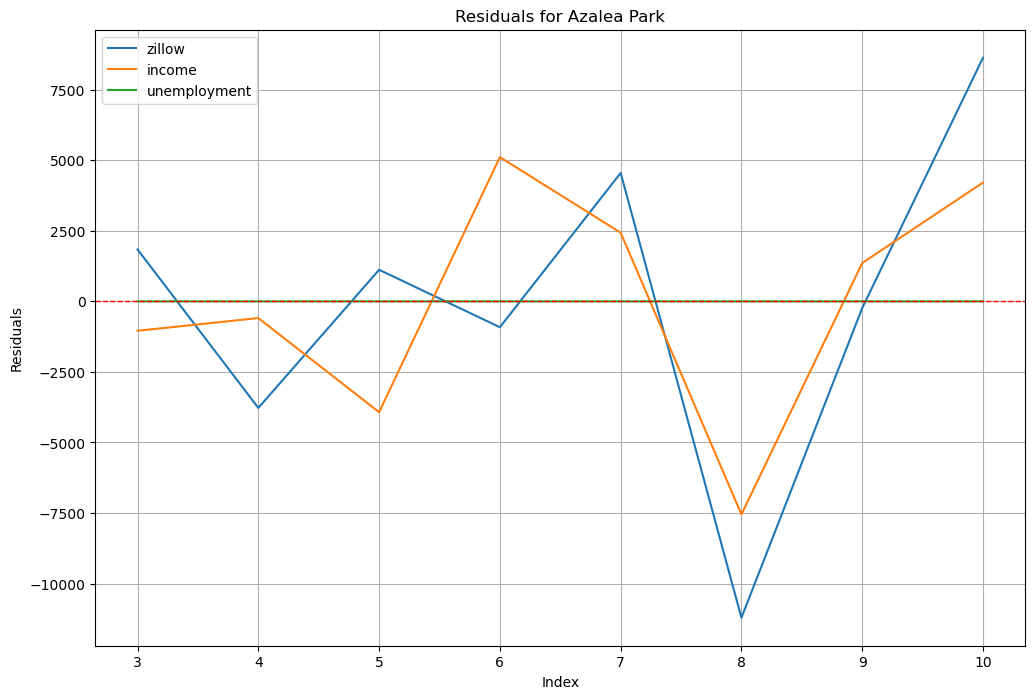

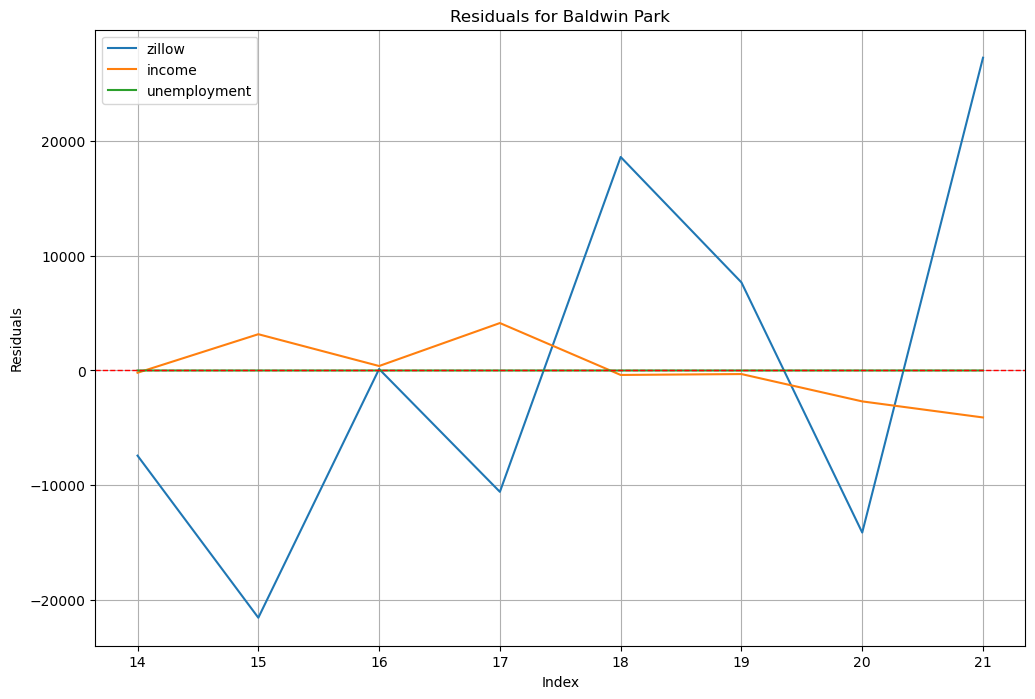

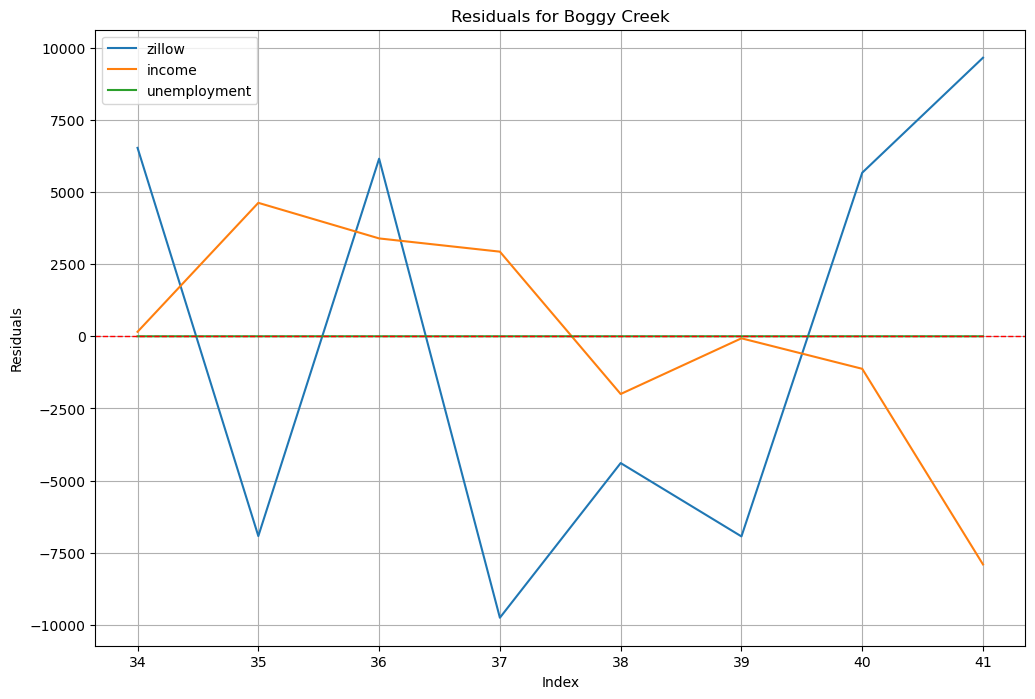

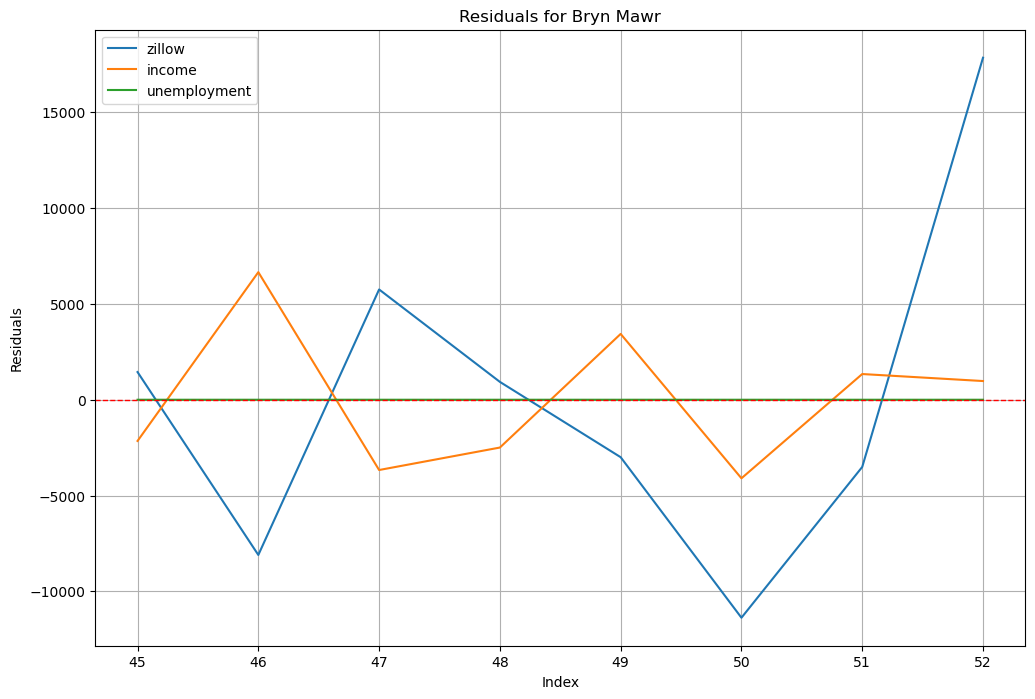

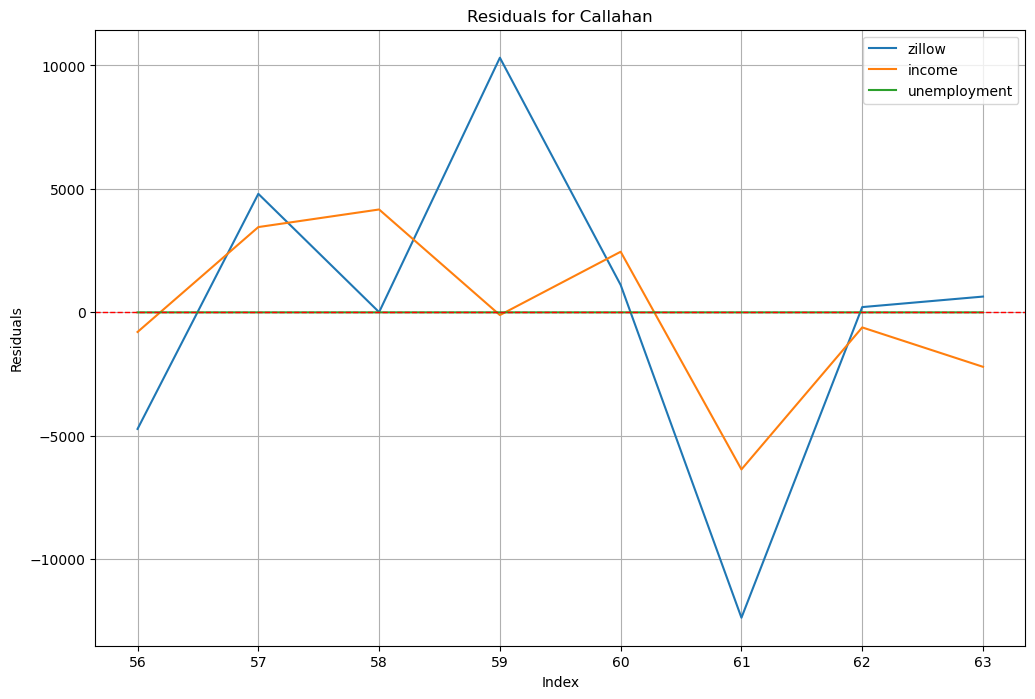

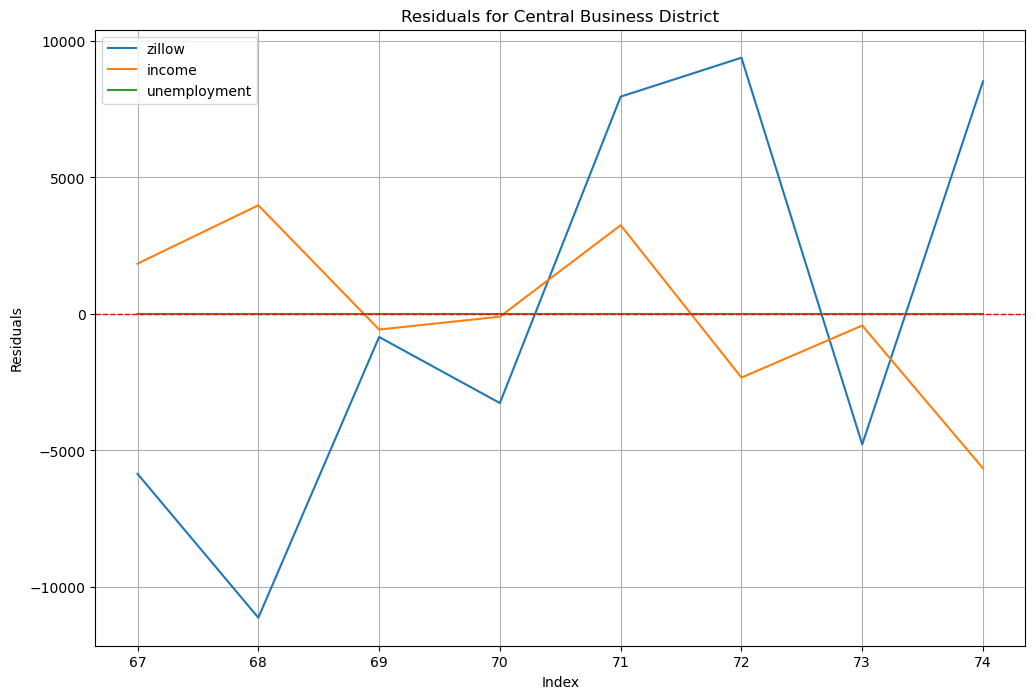

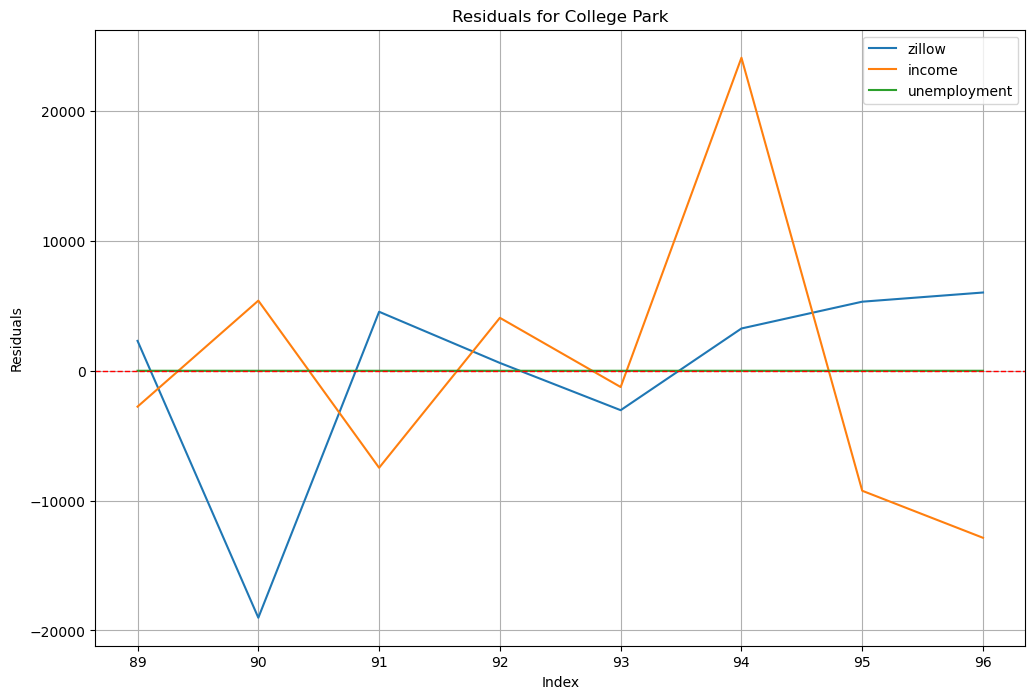

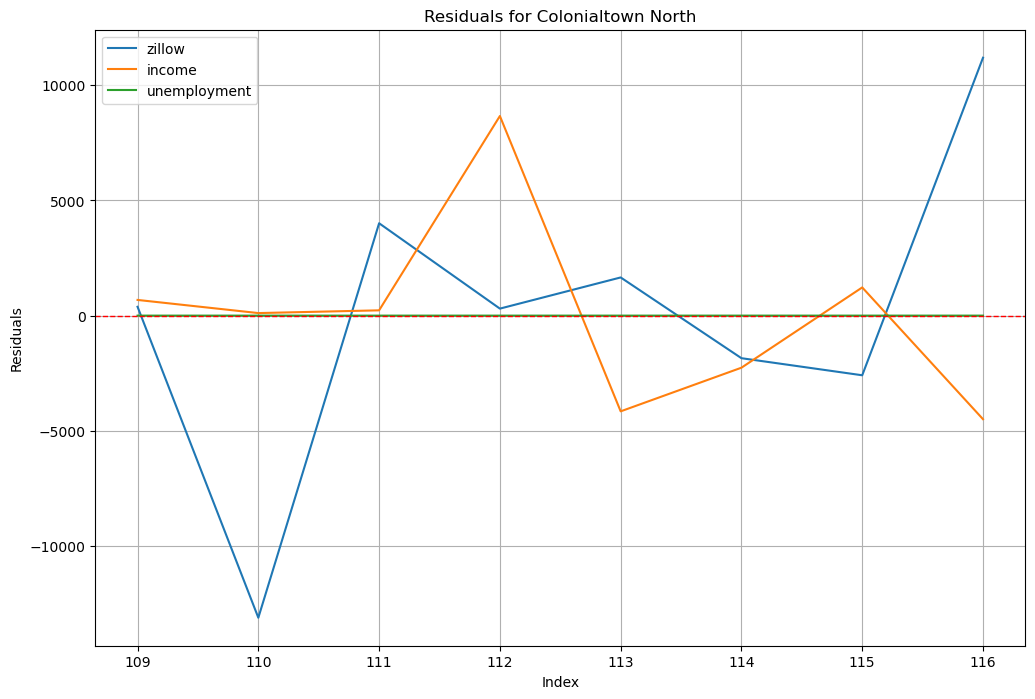

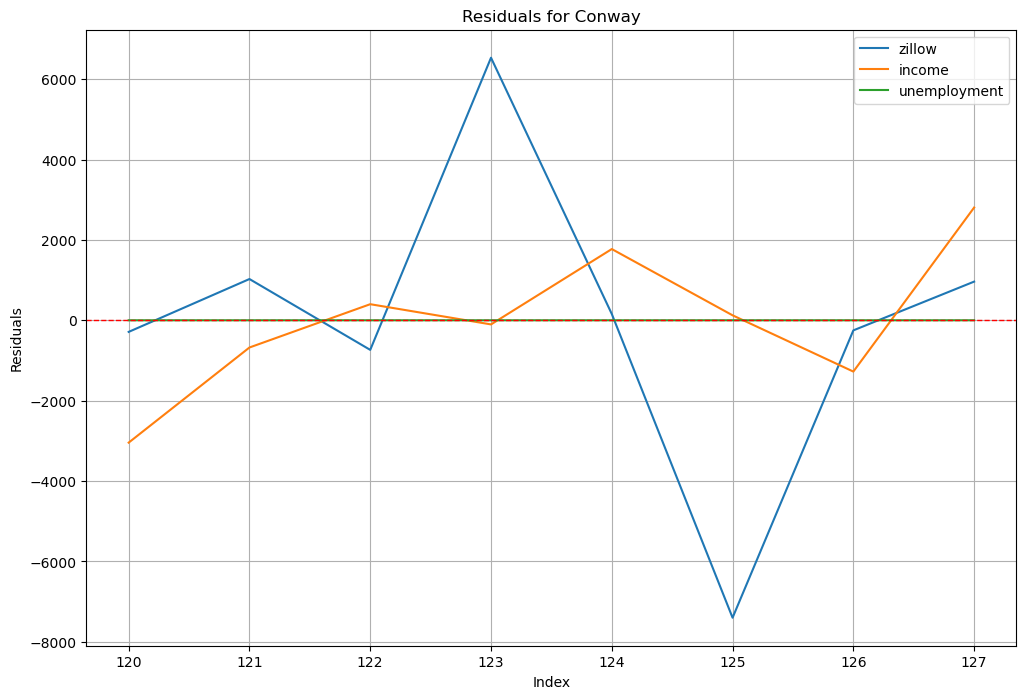

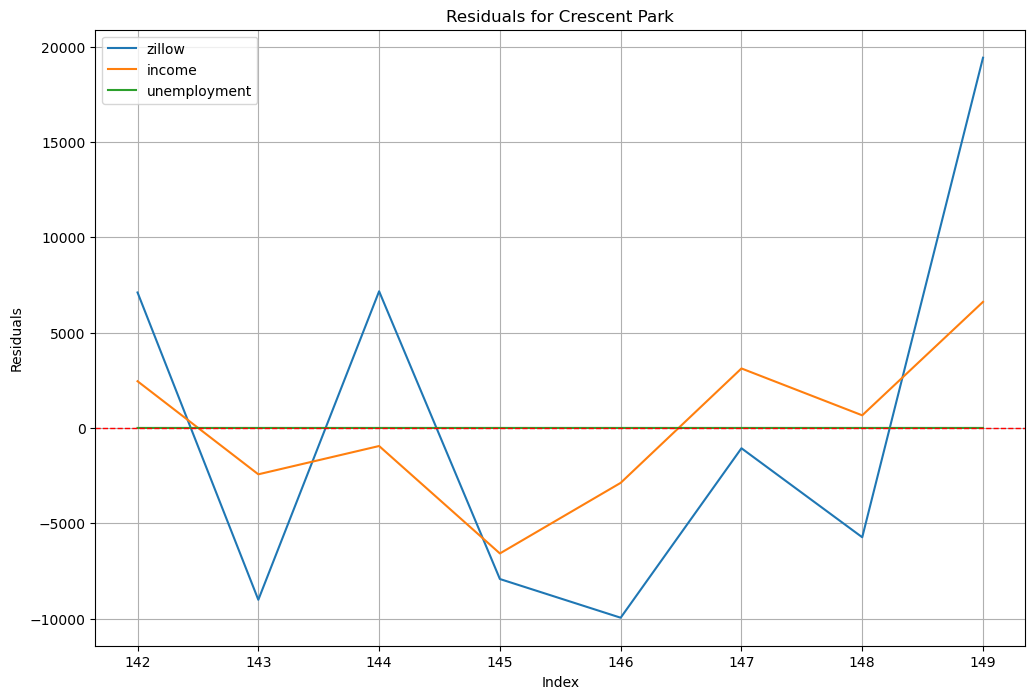

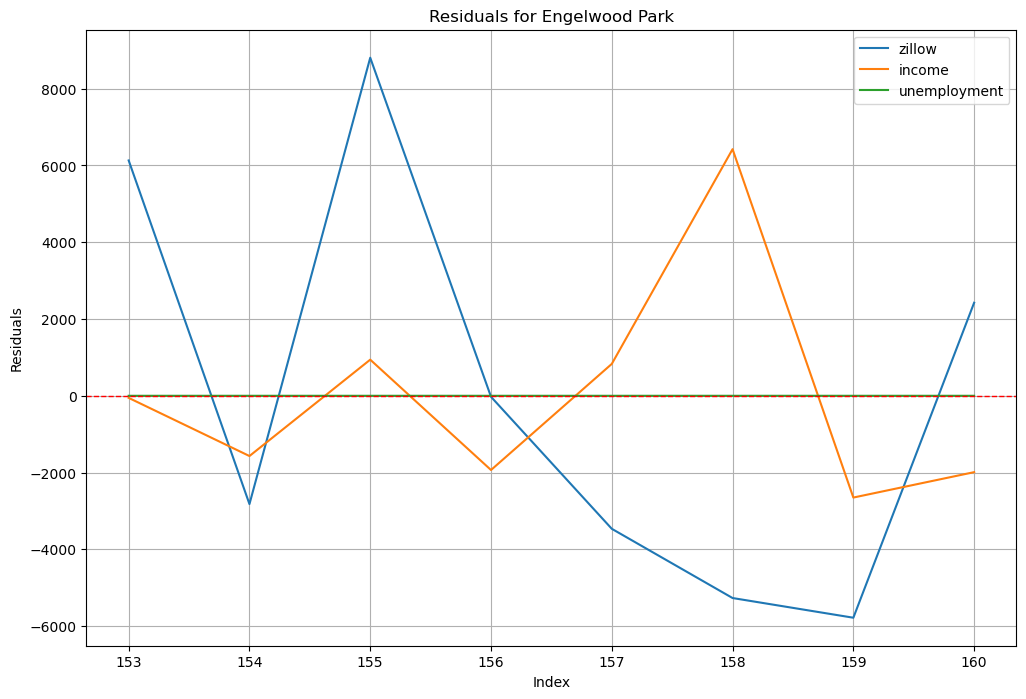

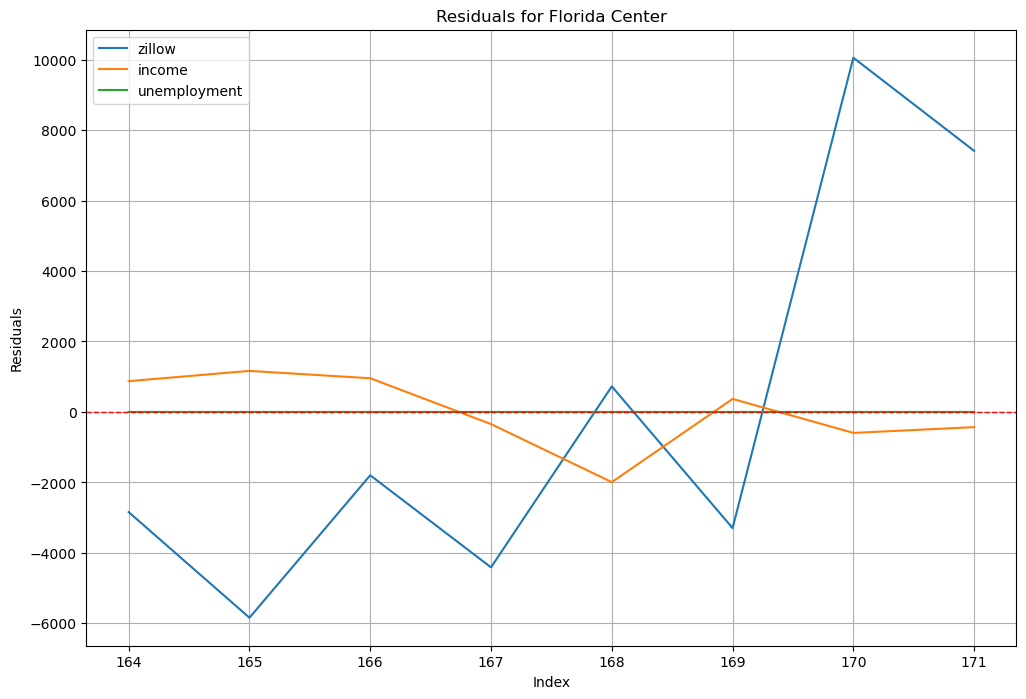

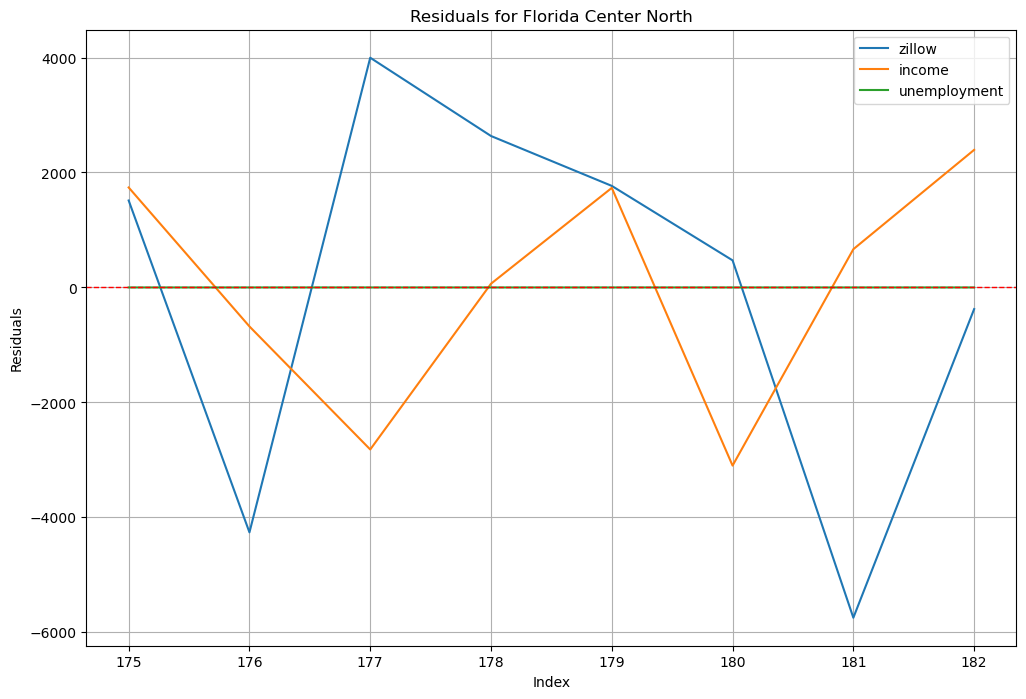

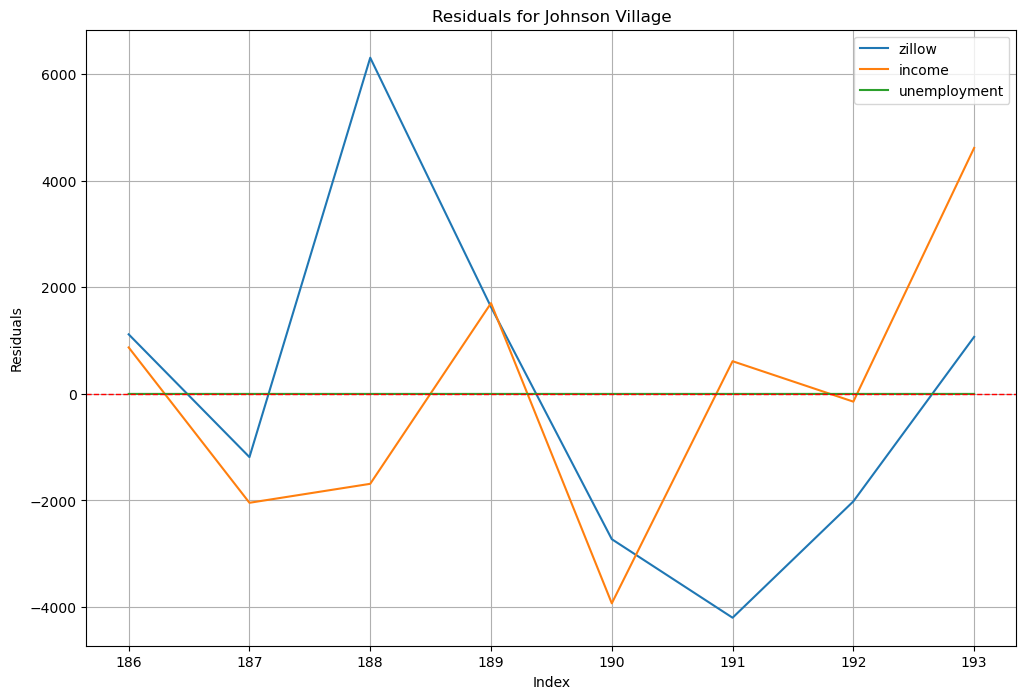

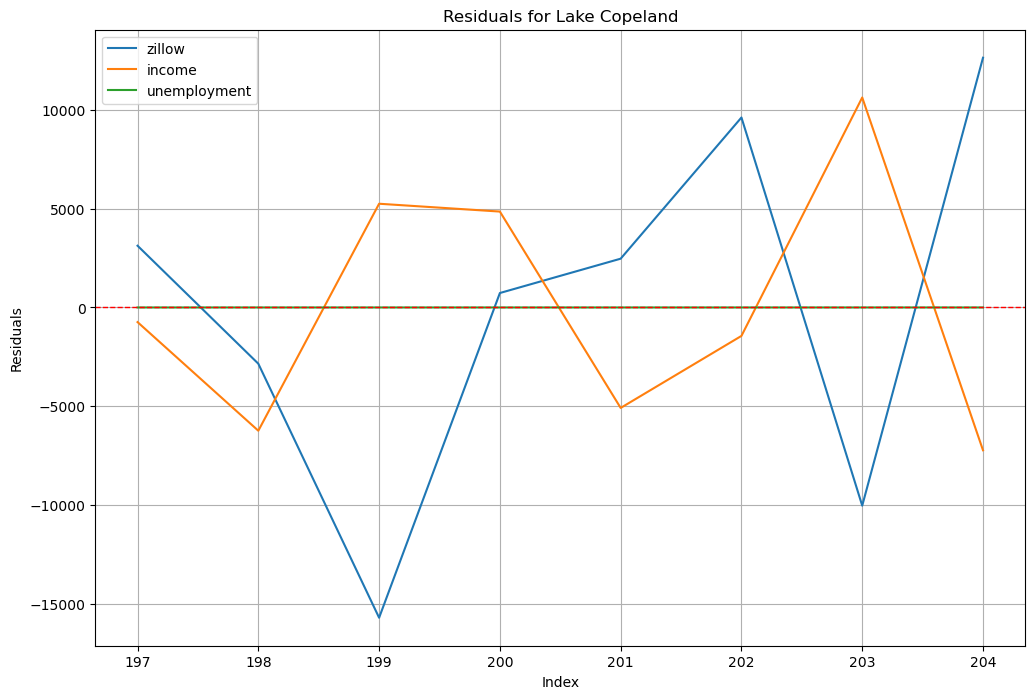

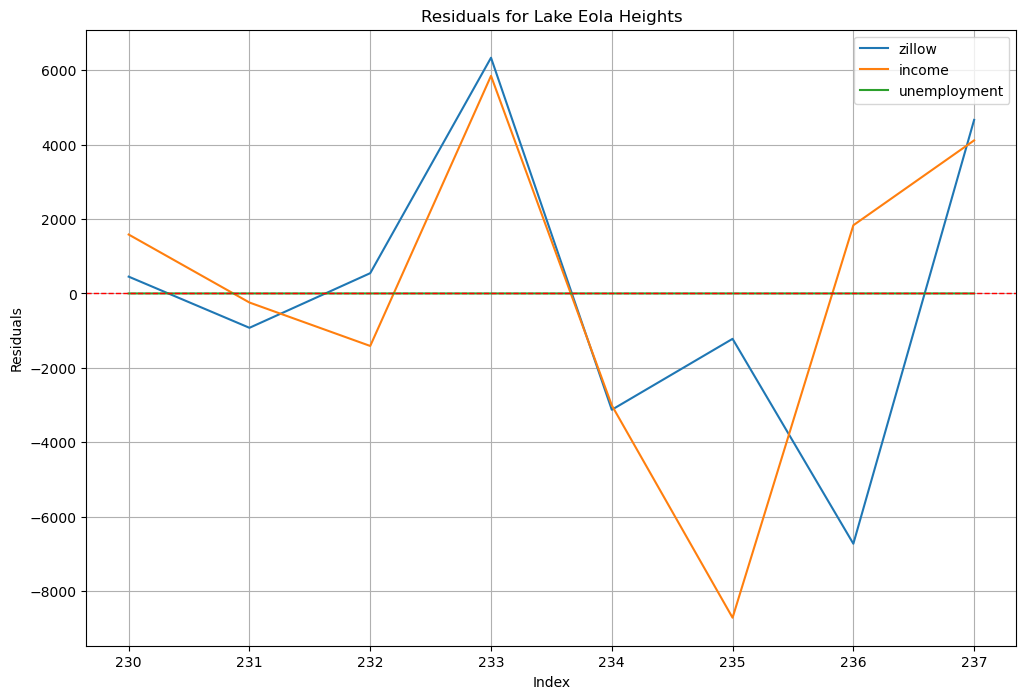

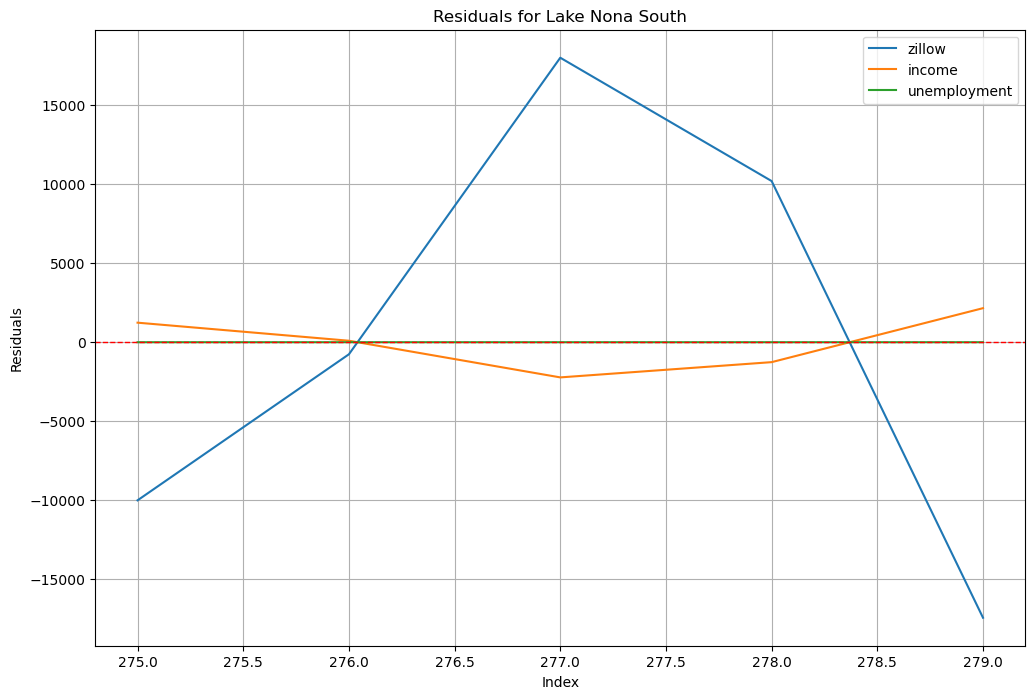

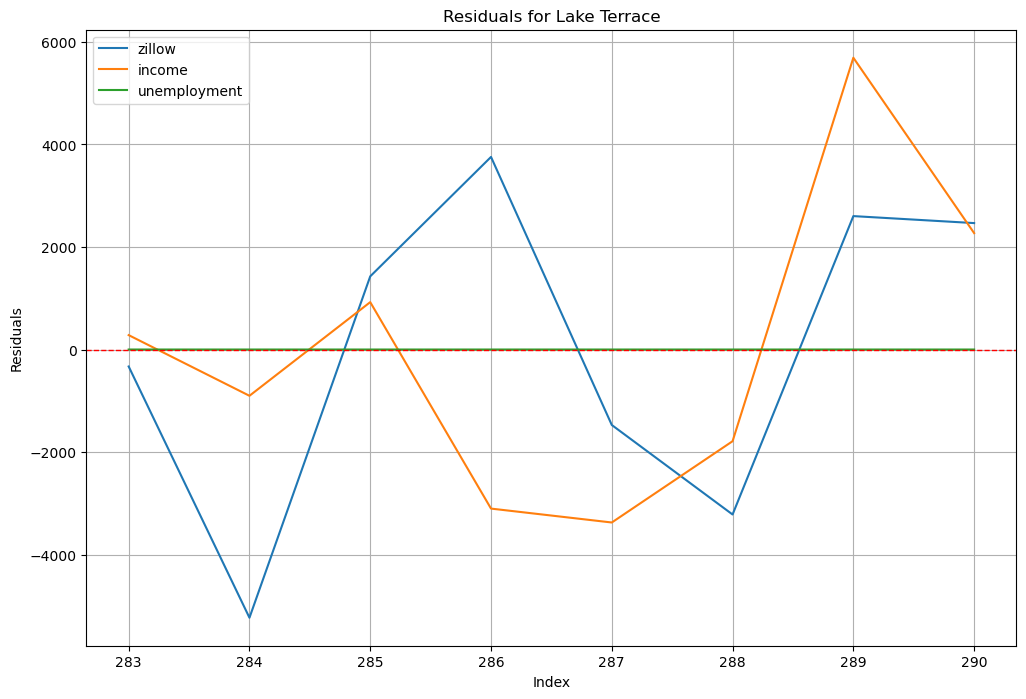

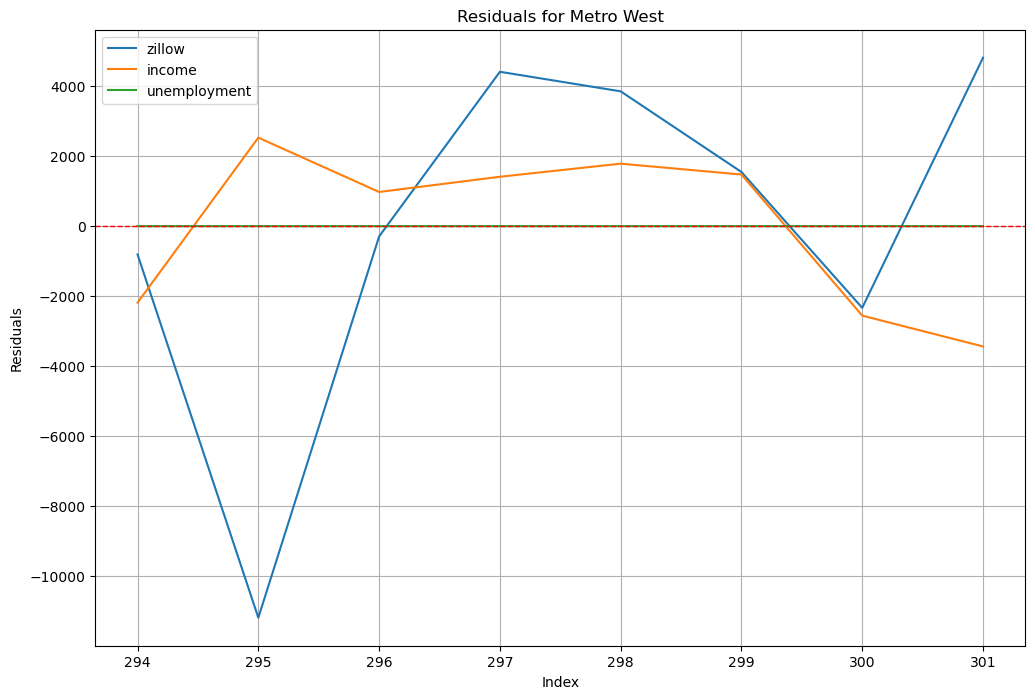

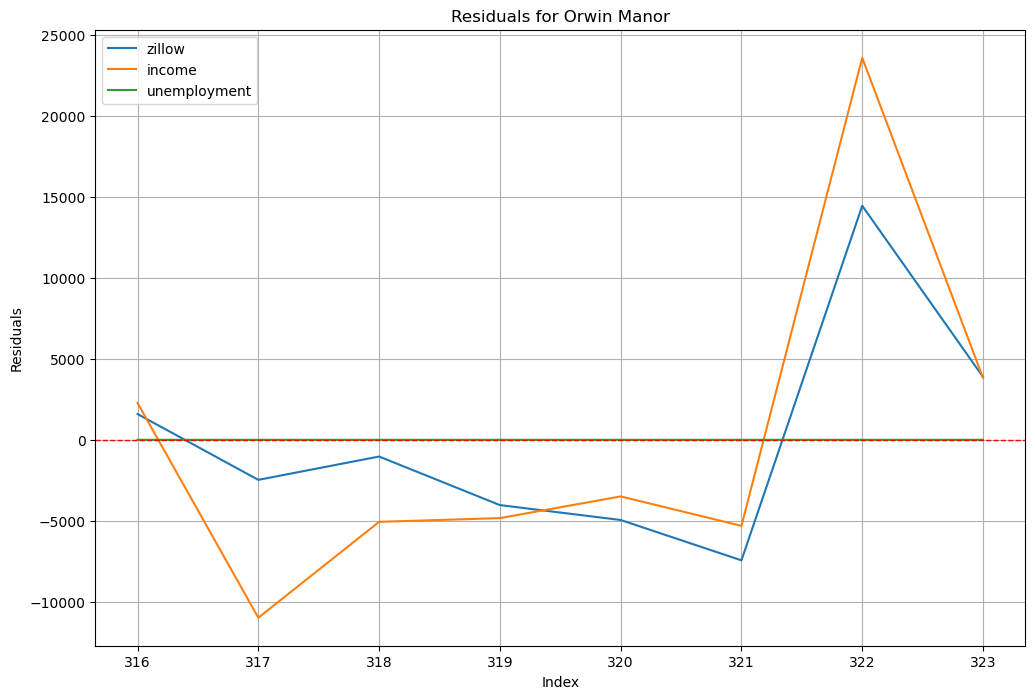

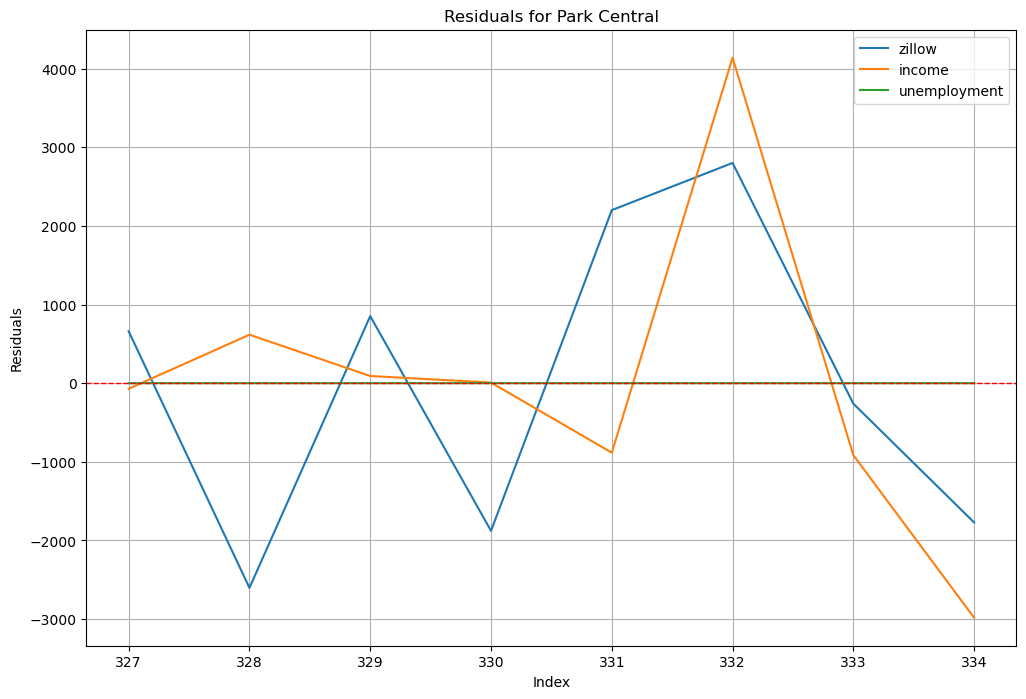

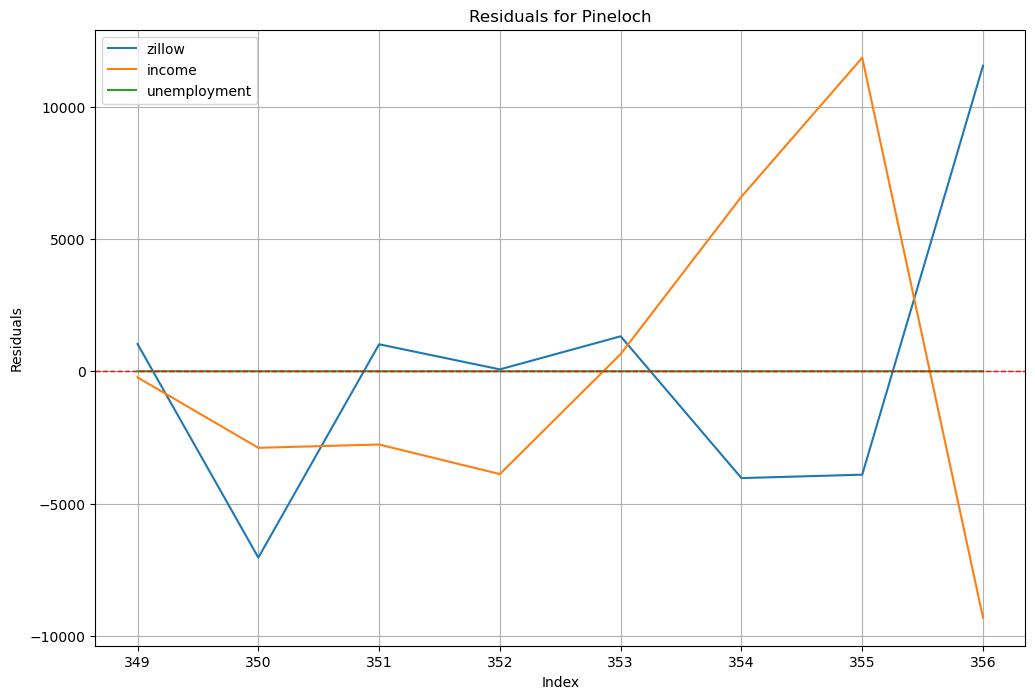

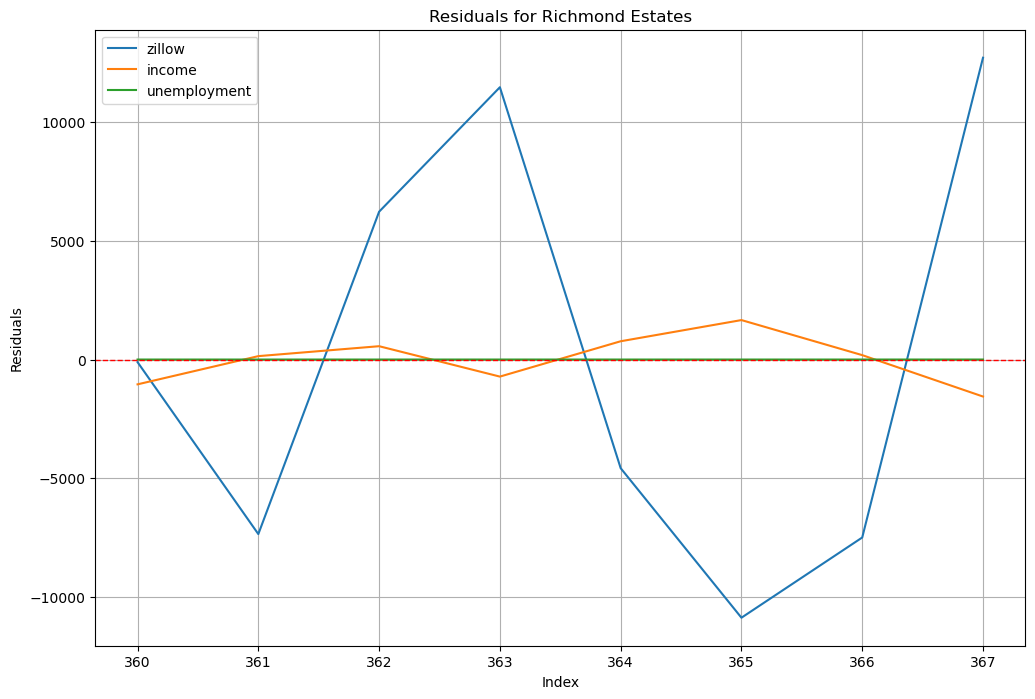

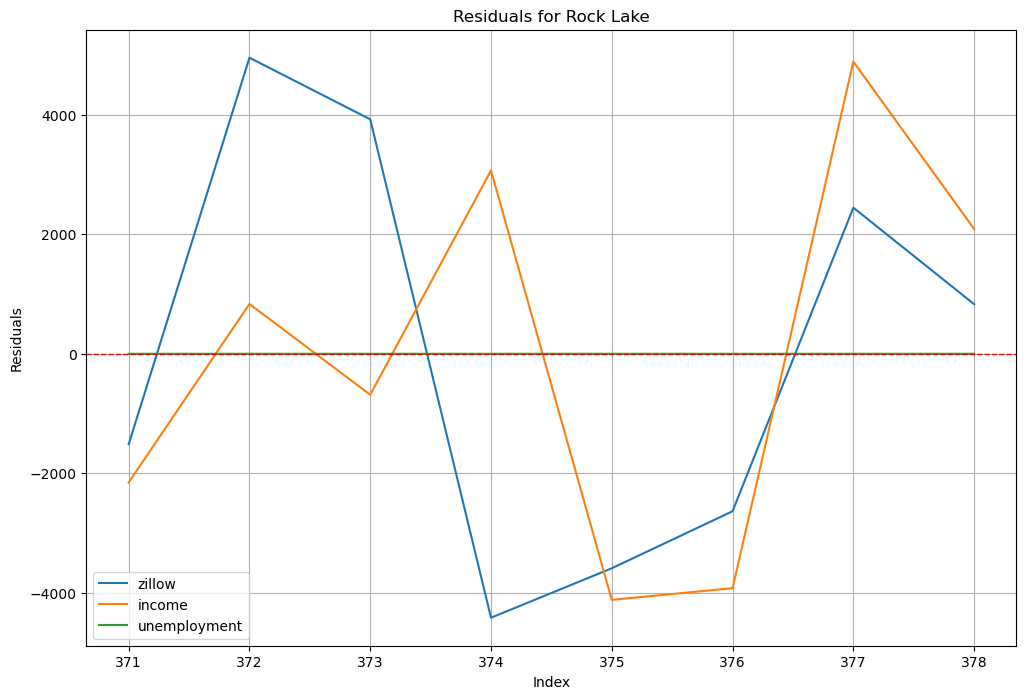

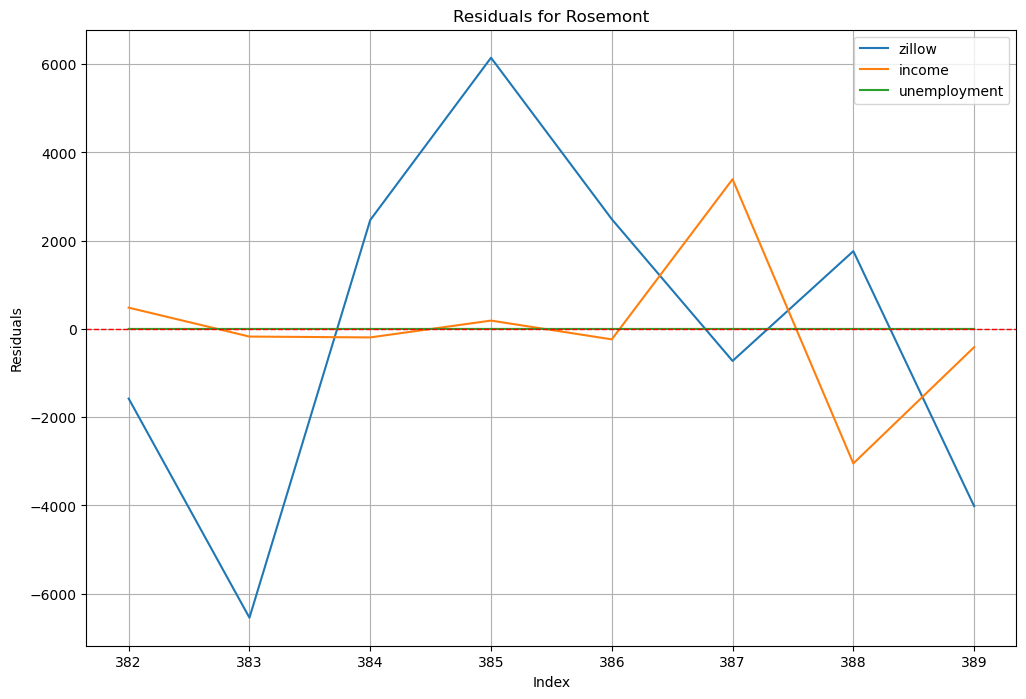

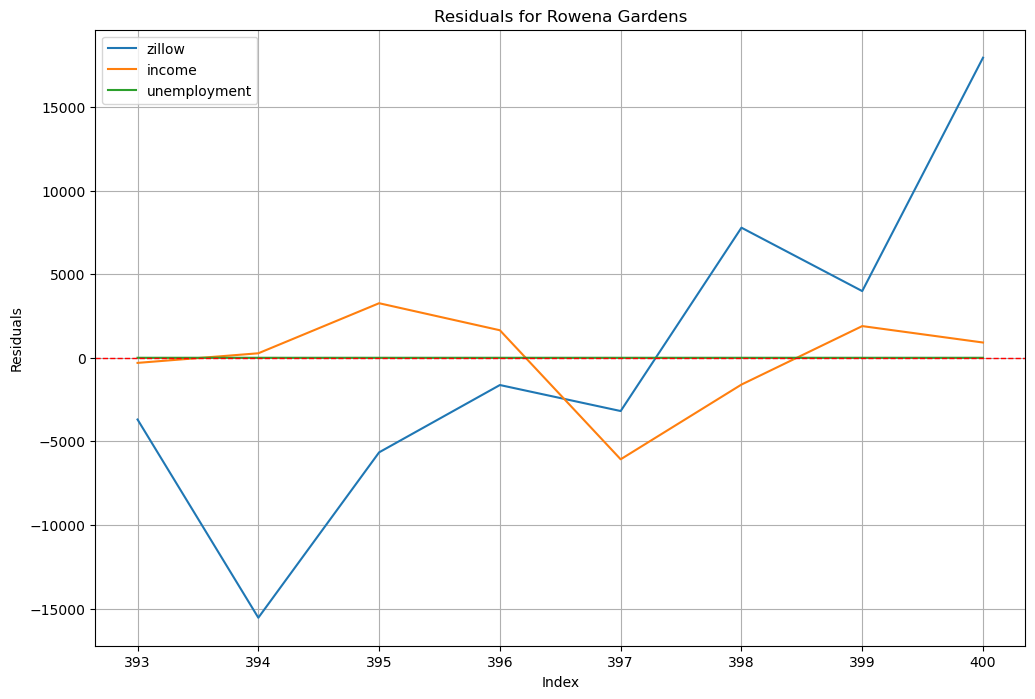

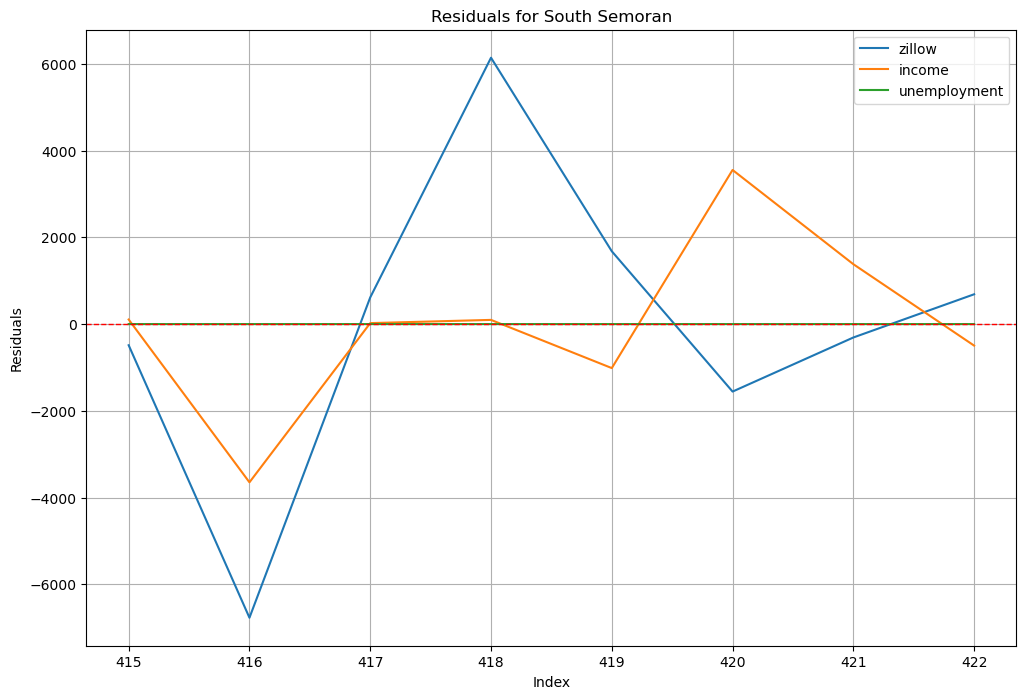

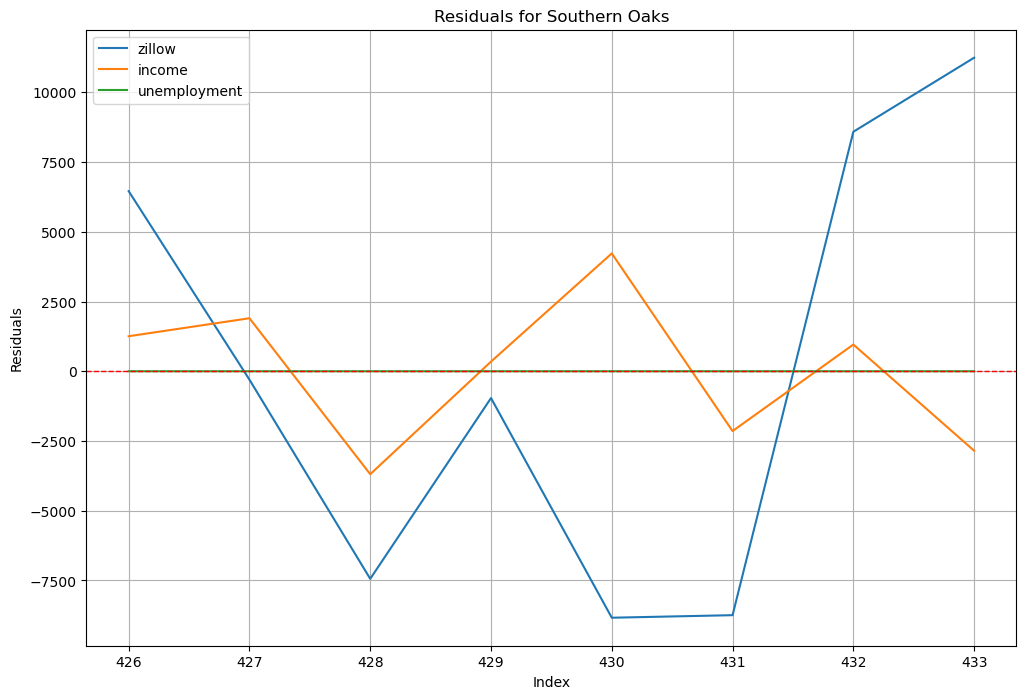

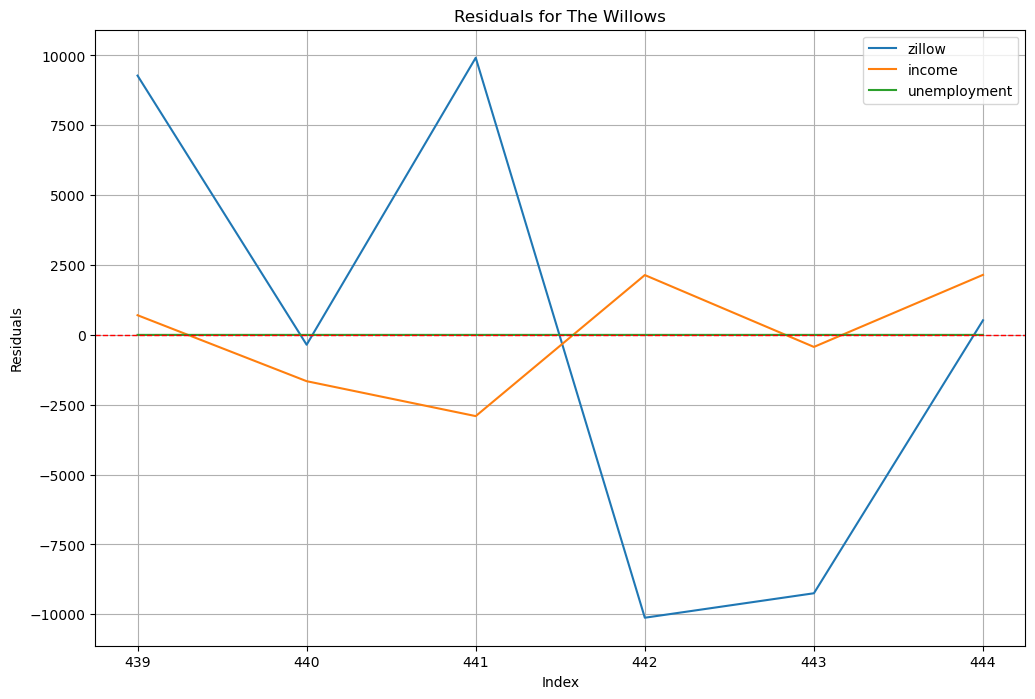

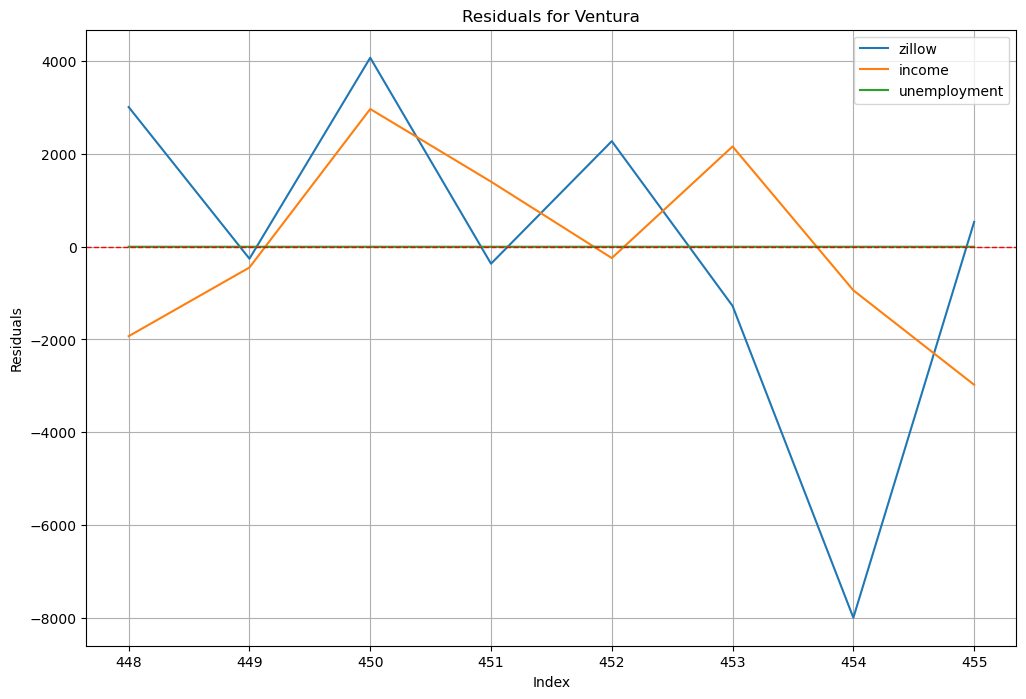

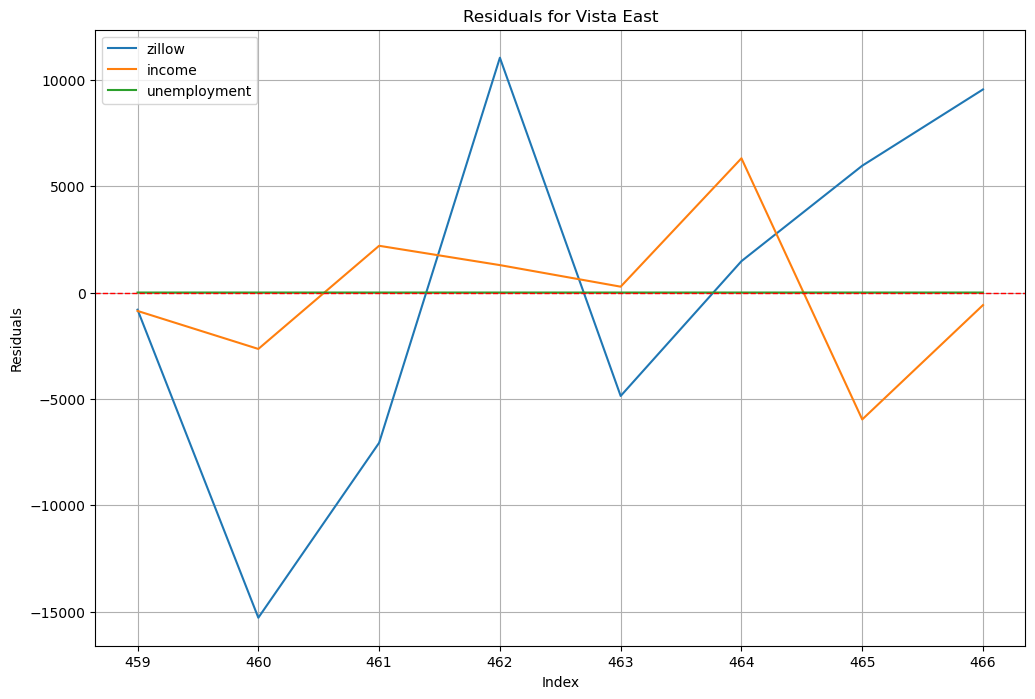

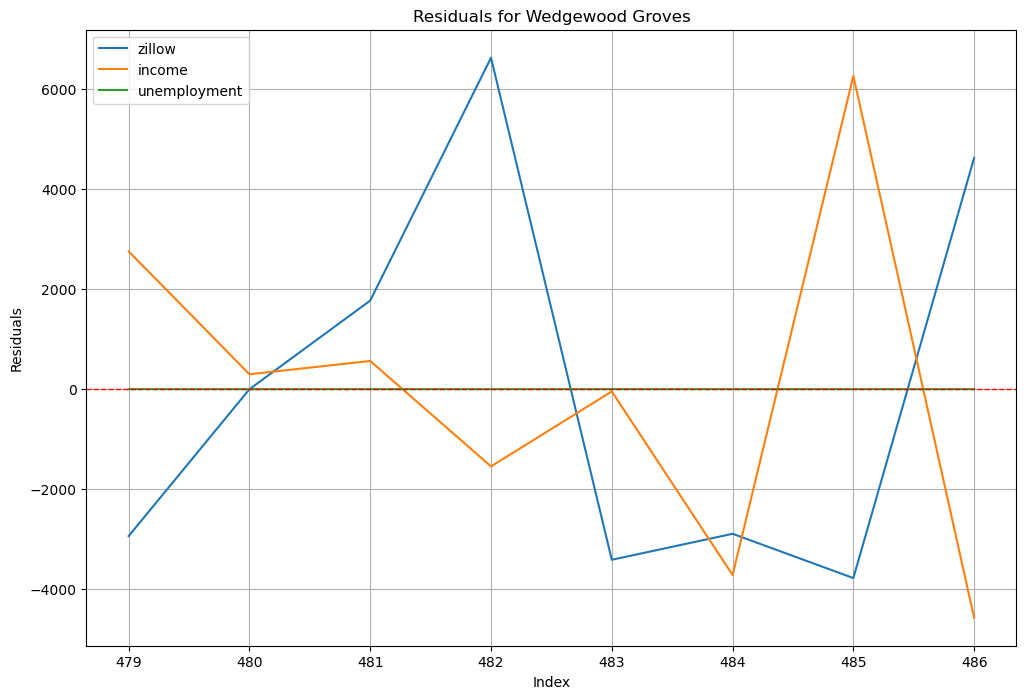

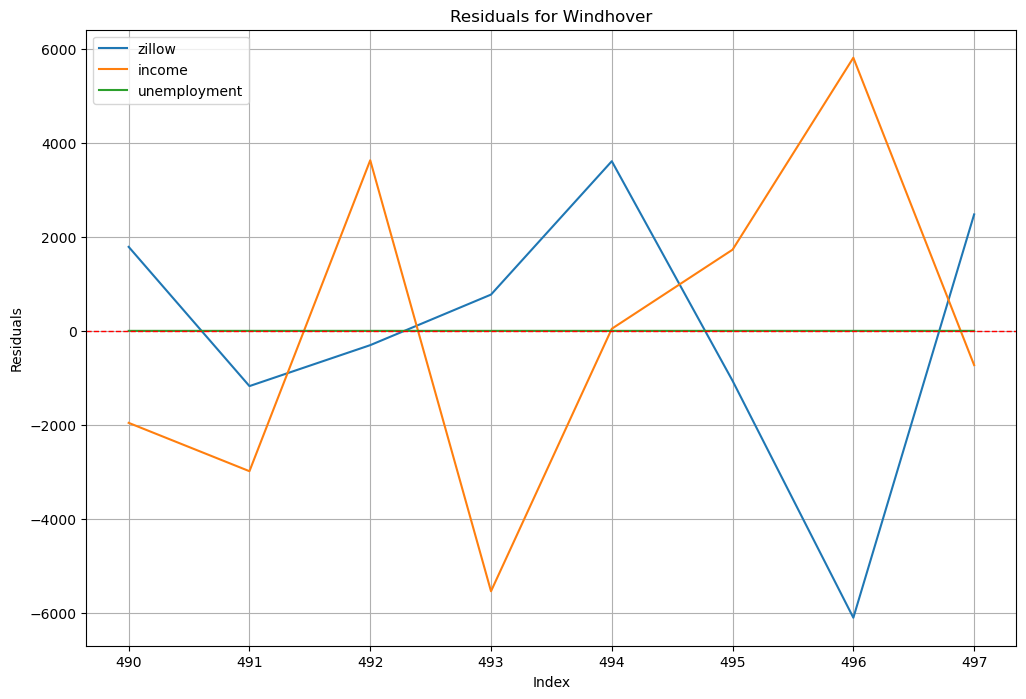

In [7]:
import matplotlib.pyplot as plt

# Iterate through each neighborhood and its corresponding model results
for neighborhood, results in grouped_results.items():
  residuals = results.resid.drop(columns=['year'], errors='ignore')  # Drop 'year' column if it exists

  # Plot all residuals on the same plot
  plt.figure(figsize=(12, 8))
  for column in residuals.columns:
    plt.plot(residuals.index, residuals[column], label=f'{column}')
  plt.axhline(0, color='red', linestyle='--', linewidth=1)
  plt.title(f'Residuals for {neighborhood}')
  plt.xlabel('Index')
  plt.ylabel('Residuals')
  plt.legend()
  plt.grid()
  plt.show()

In [8]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Your existing code here
# Container to store evaluation metrics
evaluation_metrics = {}

# Loop through each neighborhood in grouped_results
for neighborhood, results in grouped_results.items():
  # Get the original data for the neighborhood
  neighborhood_data = var_df[var_df["neighborhood"] == neighborhood].sort_values("year")
  
  # Calculate the number of rows to exclude (last 10%)
  exclude_count = max(1, int(len(neighborhood_data) * 0.1))
  
  # Leave out the last 10% of data
  train_data = neighborhood_data.iloc[:-exclude_count]
  test_data = neighborhood_data.iloc[-exclude_count:]
  
  # Prepare the training data for the VAR model
  train_df = train_data.drop(columns=["neighborhood", "distance", "duration"]).diff().diff().dropna()
  
  # Check if enough data points are available after differencing
  if len(train_df) <= 1:  # At least 2 data points needed for lag 1
    print(f"Skipping {neighborhood} due to insufficient data after differencing.")
    continue
  
  # Fit the VAR model on the training data
  model = VAR(train_df)
  results = model.fit()
  
  # Forecast the excluded observations
  forecast = results.forecast(results.endog[-results.k_ar:], steps=len(test_data))
  forecast_df = pd.DataFrame(forecast, columns=results.names)
  
  # Calculate RMSE, MAE, and MAPE for the forecasted values
  y_true = test_data[results.names].values.flatten()
  y_pred = forecast_df.values.flatten()
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # expressed as percentage
  
  # Store the metrics
  evaluation_metrics[neighborhood] = {"RMSE": rmse, "MAE": mae, "MAPE": mape}

# Convert the evaluation metrics dictionary to a DataFrame for sorting
evaluation_metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

# Sort the DataFrame by MAE and display the top 10 neighborhoods
print(evaluation_metrics_df.sort_values("MAE").head(10))

C:\Users\brad\AppData\Local\Temp\ipykernel_6480\3353340996.py:41: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # expressed as percentage


                              RMSE           MAE        MAPE
Park Central          68560.995974  40035.104871  100.987485
South Semoran         66221.349860  41607.718437  141.515015
The Willows           73194.406901  46093.572622   98.179201
Conway                73472.547058  47538.547832   98.209648
Florida Center North  75163.839219  47558.085160   90.798943
Callahan              78745.341000  49057.921291  112.462911
Ventura               82156.116987  49386.089812  101.312751
Johnson Village       81632.892993  50819.105358  102.317891
Windhover             83811.465374  51579.838847  130.949799
Rosemont              86313.647414  52037.803841  104.556861


# Prophet Model

In [9]:
from prophet import Prophet

c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [10]:
with open('../sql-scripts/prophet.txt', 'r') as sql_file:
  sql_script = sql_file.read()

conn = sqlite3.connect('orlando.db')
prophet_df = pd.read_sql_query(sql_script, conn)
conn.close()

## Fit the model and diagnostics

In [11]:
# Define an evaluation function for the test set forecast
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # expressed as percentage
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [12]:
# Ensure your date column is in datetime format and rename columns for Prophet
prophet_df["ds"] = pd.to_datetime(prophet_df["period"])
prophet_df = prophet_df.rename(columns={'value': 'y'})

# Define a cutoff date for training/test split (adjust as needed)
cutoff_date = "2023-01-01"

In [13]:
# Container to hold results for each neighborhood
results = []

# Loop over each neighborhood (using "neighborhood")
for neighborhood, group_df in prophet_df.groupby("neighborhood"):
    # Sort by date (the "ds" column)
    group_df = group_df.sort_values("ds")

    # Split the data: training before cutoff, test starting from cutoff
    train_df = group_df[group_df["ds"] < cutoff_date].copy()
    test_df  = group_df[group_df["ds"] >= cutoff_date].copy()

    # Skip neighborhoods with insufficient training or testing data
    if train_df["y"].notna().sum() < 2 or test_df["y"].notna().sum() < 1:
        print(f"Skipping {neighborhood} due to insufficient data: "
              f"train count = {train_df['y'].notna().sum()}, "
              f"test count = {test_df['y'].notna().sum()}")
        continue

    # Fit Prophet on the training data
    m = Prophet()
    try:
        result = m.fit(train_df)
    except Exception as e:
        print(f"Error fitting Prophet for {neighborhood}: {e}")
        continue

    # --- Evaluate on Test Data ---
    # Create a future dataframe covering the test period (same number of periods as in test)
    future_test = m.make_future_dataframe(periods=len(test_df), freq="ME")
    forecast_test = m.predict(future_test)

    # Select only the forecasted values in the test period (using the cutoff date)
    forecast_test = forecast_test[forecast_test["ds"] >= cutoff_date]
    y_true = test_df["y"].values
    y_pred = forecast_test["yhat"].values
    metrics_dict = evaluate_forecast(y_true, y_pred)

    # --- Forecast 10 Years into the Future ---
    future_8yr = m.make_future_dataframe(periods=120, freq="ME")
    forecast_8yr = m.predict(future_8yr)

    # Collect results for the current region
    results.append({
        "neighborhood": neighborhood,
        "model": result,
        "metrics": metrics_dict,
        "forecast_test": forecast_test,
        "forecast_8yr": forecast_8yr
    })

# Convert the results list to a DataFrame of metrics (for summary, if desired)
metrics_df = pd.DataFrame([{"neighborhood": r["neighborhood"], **r["metrics"]} for r in results])

print(metrics_df.sort_values("MAE").head(10))

00:36:24 - cmdstanpy - INFO - Chain [1] start processing
00:36:24 - cmdstanpy - INFO - Chain [1] done processing
00:36:25 - cmdstanpy - INFO - Chain [1] start processing
00:36:25 - cmdstanpy - INFO - Chain [1] done processing
00:36:25 - cmdstanpy - INFO - Chain [1] start processing
00:36:25 - cmdstanpy - INFO - Chain [1] done processing
00:36:25 - cmdstanpy - INFO - Chain [1] start processing
00:36:25 - cmdstanpy - INFO - Chain [1] done processing
00:36:26 - cmdstanpy - INFO - Chain [1] start processing
00:36:26 - cmdstanpy - INFO - Chain [1] done processing
00:36:26 - cmdstanpy - INFO - Chain [1] start processing
00:36:26 - cmdstanpy - INFO - Chain [1] done processing
00:36:27 - cmdstanpy - INFO - Chain [1] start processing
00:36:27 - cmdstanpy - INFO - Chain [1] done processing
00:36:27 - cmdstanpy - INFO - Chain [1] start processing
00:36:27 - cmdstanpy - INFO - Chain [1] done processing
00:36:28 - cmdstanpy - INFO - Chain [1] start processing
00:36:28 - cmdstanpy - INFO - Chain [1]

Skipping Countryside due to insufficient data: train count = 0, test count = 16


00:36:33 - cmdstanpy - INFO - Chain [1] done processing
00:36:33 - cmdstanpy - INFO - Chain [1] start processing
00:36:33 - cmdstanpy - INFO - Chain [1] done processing
00:36:34 - cmdstanpy - INFO - Chain [1] start processing
00:36:34 - cmdstanpy - INFO - Chain [1] done processing
00:36:34 - cmdstanpy - INFO - Chain [1] start processing
00:36:34 - cmdstanpy - INFO - Chain [1] done processing
00:36:35 - cmdstanpy - INFO - Chain [1] start processing
00:36:35 - cmdstanpy - INFO - Chain [1] done processing
00:36:35 - cmdstanpy - INFO - Chain [1] start processing
00:36:35 - cmdstanpy - INFO - Chain [1] done processing
00:36:36 - cmdstanpy - INFO - Chain [1] start processing
00:36:36 - cmdstanpy - INFO - Chain [1] done processing
00:36:36 - cmdstanpy - INFO - Chain [1] start processing
00:36:36 - cmdstanpy - INFO - Chain [1] done processing
00:36:37 - cmdstanpy - INFO - Chain [1] start processing
00:36:37 - cmdstanpy - INFO - Chain [1] done processing
00:36:37 - cmdstanpy - INFO - Chain [1] 

Skipping New Malibu due to insufficient data: train count = 0, test count = 16


00:36:54 - cmdstanpy - INFO - Chain [1] start processing
00:36:54 - cmdstanpy - INFO - Chain [1] done processing
00:36:55 - cmdstanpy - INFO - Chain [1] start processing
00:36:55 - cmdstanpy - INFO - Chain [1] done processing
00:36:55 - cmdstanpy - INFO - Chain [1] start processing
00:36:55 - cmdstanpy - INFO - Chain [1] done processing
00:36:56 - cmdstanpy - INFO - Chain [1] start processing
00:36:56 - cmdstanpy - INFO - Chain [1] done processing
00:36:56 - cmdstanpy - INFO - Chain [1] start processing
00:36:56 - cmdstanpy - INFO - Chain [1] done processing
00:36:56 - cmdstanpy - INFO - Chain [1] start processing
00:36:57 - cmdstanpy - INFO - Chain [1] done processing
00:36:57 - cmdstanpy - INFO - Chain [1] start processing
00:36:57 - cmdstanpy - INFO - Chain [1] done processing
00:36:58 - cmdstanpy - INFO - Chain [1] start processing
00:36:58 - cmdstanpy - INFO - Chain [1] done processing
00:36:58 - cmdstanpy - INFO - Chain [1] start processing
00:36:59 - cmdstanpy - INFO - Chain [1]

          neighborhood          MAE          RMSE      MAPE
105      West Colonial  4841.729449   5839.360707  2.065763
63         Mercy Drive  5060.798727   6601.158836  2.336680
79           Rock Lake  6920.117633   8051.869511  2.308034
42           Lake Como  7182.379410  10657.643009  1.542376
26   East Central Park  7269.645339   8999.510122  2.046925
3          Azalea Park  7317.873654   9525.279908  2.305917
18             Coytown  7511.898696   9630.456031  1.793067
29     Fairview Shores  7625.146262   8756.546729  2.322915
77    Richmond Heights  7713.035540  10677.516872  3.188346
85         Signal Hill  7796.336410   9413.753277  3.024245


## Forecast model

In [14]:
# Create a DataFrame to store yearly forecasts for each neighborhood
yearly_forecast_df = pd.DataFrame()

# Loop through each neighborhood's forecast in the results
for result in results:
    neighborhood = result["neighborhood"]
    forecast_8yr = result["forecast_8yr"]

    # Extract the year from the 'ds' column and calculate the yearly average
    forecast_8yr["year"] = forecast_8yr["ds"].dt.year
    yearly_avg = forecast_8yr.groupby("year")["yhat"].mean()

    # If the DataFrame is empty, initialize it with the years as the index
    if yearly_forecast_df.empty:
        yearly_forecast_df = pd.DataFrame(index=yearly_avg.index)

    # Add the yearly averages as a column in the DataFrame
    yearly_forecast_df[neighborhood] = yearly_avg

# Transpose the DataFrame for better readability (neighborhoods as rows, years as columns)
yearly_forecast_df = yearly_forecast_df.T

# Filter the DataFrame to include only columns from 2022 to 2030
yearly_forecast_df = yearly_forecast_df.loc[:, 2022:2030]

# Display the filtered DataFrame
print(yearly_forecast_df)

year                        2022           2023           2024           2025  \
Airport North      245563.893937  268773.835814  291919.262589  315220.631149   
Alafaya            396430.785795  427371.701916  458059.801530  489323.347491   
Audubon Park       414180.388614  446574.649879  479016.900787  511427.746004   
Azalea Park        276230.475330  302147.719233  328020.731819  354040.450572   
Baldwin Park       637704.153168  678590.685326  719330.699976  760427.051243   
...                          ...            ...            ...            ...   
Washington Shores  203742.022058  229943.827545  256036.615741  282420.078824   
Wedgewood Groves   347118.454599  374806.324320  402434.403886  430228.128149   
West Colonial      197094.349708  218998.175332  240821.119619  262849.369924   
Williamsburg       346960.155115  411738.326557  477092.360039  541497.406351   
Windhover          176267.040289  192898.838538  209632.852176  226189.542543   

year                       

C:\Users\brad\AppData\Local\Temp\ipykernel_6480\761905847.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yearly_forecast_df[neighborhood] = yearly_avg
C:\Users\brad\AppData\Local\Temp\ipykernel_6480\761905847.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yearly_forecast_df[neighborhood] = yearly_avg
C:\Users\brad\AppData\Local\Temp\ipykernel_6480\761905847.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

In [15]:
# Melt the yearly_forecast_df dataframe
prophet_forecast = yearly_forecast_df.reset_index().melt(id_vars='index', var_name='period', value_name='value')

# Rename the 'index' column to 'neighborhood'
prophet_forecast.rename(columns={'index': 'neighborhood'}, inplace=True)

# Adding forecasts and models to database

In [16]:
# Read the forecast.txt SQL script
with open('../sql-scripts/forecast.txt', 'r') as sql_file:
  sql_script = sql_file.read()

# Connect to the SQLite database
with sqlite3.connect('orlando.db') as conn:
  # Execute the SQL script to create the tables
  conn.executescript(sql_script)
  var_forecast.to_sql('var_forecast', conn, if_exists='append', index=False)
  prophet_forecast.to_sql('prophet_forecast', conn, if_exists='append', index=False)

In [17]:
import pickle

with open('../sql-scripts/models.txt', 'r') as sql_file:
  sql_script = sql_file.read()

# Prepare data for insertion into the models table
models_data = []

# Add VAR models
for neighborhood, model in grouped_results.items():
  # Serialize the VAR model using pickle
  serialized_model = pickle.dumps(model)
  models_data.append({"neighborhood": neighborhood, "model": "VAR", "value": serialized_model})

# Add Prophet models
for result in results:
  # Serialize the Prophet model using pickle
  serialized_model = pickle.dumps(result["model"])
  models_data.append({"neighborhood": result["neighborhood"], "model": "prophet", "value": serialized_model})

# Convert the data to a DataFrame
models_df = pd.DataFrame(models_data)

# Store the data in the models table
with sqlite3.connect('orlando.db') as conn:
  conn.executescript(sql_script)
  models_df.to_sql('models', conn, if_exists='append', index=False)